In [1]:
import time
start = time.perf_counter()

In [2]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

# GPU running out of memory, testing enabling memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)
# GPU running out of memory, testing enabling memory growth

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

2026-02-19 14:25:06.843330: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771529106.858693   18739 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771529106.863332   18739 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771529106.875042   18739 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771529106.875063   18739 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771529106.875065   18739 computation_placer.cc:177] computation placer alr

In [3]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [4]:
print(tf.__version__)

2.19.1


In [5]:
tf.random.set_seed(42)
np.random.seed(42)

In [6]:
train_df = pd.read_csv('../data/train.csv', index_col=0)
val_df = pd.read_csv('../data/val.csv', index_col=0)
test_df = pd.read_csv('../data/test.csv', index_col=0)

print(train_df.shape, val_df.shape, test_df.shape)

(12285, 5) (3510, 5) (1756, 5)


In [7]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='traffic_volume', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

In [8]:
# def compile_and_fit(model, window, patience=3, max_epochs=50):
#     early_stopping = EarlyStopping(monitor='val_loss',
#                                    patience=patience,
#                                    mode='min')
    
#     model.compile(loss=MeanSquaredError(),
#                   optimizer=Adam(),
#                   metrics=[MeanAbsoluteError()])
    
#     history = model.fit(window.train,
#                        epochs=max_epochs,
#                        validation_data=window.val,
#                        callbacks=[early_stopping])
    
#     return history

In [9]:
def compile_and_fit(model, window, batch_size=32, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train.unbatch().batch(batch_size),
                       epochs=max_epochs,
                       validation_data=window.val.unbatch().batch(batch_size),
                       callbacks=[early_stopping])
    
    return history

In [10]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

## LSTM 

### Single-step model 

In [11]:
single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['traffic_volume']) 
wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['traffic_volume'])

In [12]:
# Values obtained from chapter 14

mae_val = [0.083, 0.068, 0.033]
mae_test = [0.081, 0.068, 0.029]

In [13]:
# lstm_model = Sequential([
#     #LSTM(32, return_sequences=True, implementation=1),  # forces non-cuDNN path
#     LSTM(32, return_sequences=True, input_shape=(24, 5), recurrent_dropout=0.0, unroll=False, use_bias=True, activation='tanh', recurrent_activation='sigmoid'),
#     Dense(units=1)
# ])
# the cuDNN LSTM kernel is broken for your specific setup (TF 2.20 + cuDNN 9 + CUDA 12.5)
lstm_model = Sequential([
    tf.keras.layers.RNN(
        tf.keras.layers.LSTMCell(32),
        return_sequences=True
    ),
    Dense(units=1)
])

history = compile_and_fit(lstm_model, wide_window, batch_size=32)   # , batch_size=32 added because running out of GPU memory

val_performance = {}
performance = {}

val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

I0000 00:00:1771529108.566151   18739 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9826 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:02:00.0, compute capability: 6.1


Epoch 1/50


I0000 00:00:1771529110.930321   18771 service.cc:152] XLA service 0x7aa880005290 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1771529110.930340   18771 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2026-02-19 14:25:10.964257: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1771529111.152830   18771 cuda_dnn.cc:529] Loaded cuDNN version 90300


     39/Unknown 2s 4ms/step - loss: 0.2791 - mean_absolute_error: 0.4405

I0000 00:00:1771529111.911480   18771 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


    384/Unknown 4s 6ms/step - loss: 0.0914 - mean_absolute_error: 0.2145

2026-02-19 14:25:14.219240: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2026-02-19 14:25:14.219262: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2026-02-19 14:25:14.219378: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:25:14.219401: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


384/384 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0412 - mean_absolute_error: 0.1405 - val_loss: 0.0140 - val_mean_absolute_error: 0.0871
Epoch 2/50
 42/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0134 - mean_absolute_error: 0.0852

2026-02-19 14:25:15.253142: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2026-02-19 14:25:15.253163: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:25:15.253172: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


372/384 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0110 - mean_absolute_error: 0.0763

2026-02-19 14:25:16.574644: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:25:16.574678: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:25:16.776395: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2026-02-19 14:25:16.776415: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:25:16.776424: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0089 - mean_absolute_error: 0.0679 - val_loss: 0.0059 - val_mean_absolute_error: 0.0553
Epoch 3/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0051 - mean_absolute_error: 0.0509 - val_loss: 0.0042 - val_mean_absolute_error: 0.0460
Epoch 4/50
 39/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0044 - mean_absolute_error: 0.0472

2026-02-19 14:25:18.260969: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:25:18.261022: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0042 - mean_absolute_error: 0.0455 - val_loss: 0.0037 - val_mean_absolute_error: 0.0428
Epoch 5/50


2026-02-19 14:25:19.602001: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:25:19.602033: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:25:19.794235: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2026-02-19 14:25:19.794256: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:25:19.794266: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


379/384 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0039 - mean_absolute_error: 0.0437

2026-02-19 14:25:21.086326: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:25:21.086364: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0038 - mean_absolute_error: 0.0430 - val_loss: 0.0035 - val_mean_absolute_error: 0.0419
Epoch 6/50
 26/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0036 - mean_absolute_error: 0.0423

2026-02-19 14:25:21.294326: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:25:21.294349: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


372/384 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0036 - mean_absolute_error: 0.0418

2026-02-19 14:25:22.619662: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:25:22.619685: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


384/384 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0036 - mean_absolute_error: 0.0413 - val_loss: 0.0032 - val_mean_absolute_error: 0.0395
Epoch 7/50
 48/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0034 - mean_absolute_error: 0.0407

2026-02-19 14:25:25.085318: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0034 - mean_absolute_error: 0.0401 - val_loss: 0.0029 - val_mean_absolute_error: 0.0378


2026-02-19 14:25:26.384786: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:25:26.384808: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:25:26.582940: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:25:26.582960: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


Epoch 8/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0032 - mean_absolute_error: 0.0392 - val_loss: 0.0028 - val_mean_absolute_error: 0.0370
Epoch 9/50


2026-02-19 14:25:27.882188: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:25:28.080009: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2026-02-19 14:25:28.080029: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:25:28.080037: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0031 - mean_absolute_error: 0.0382 - val_loss: 0.0027 - val_mean_absolute_error: 0.0364


2026-02-19 14:25:29.447272: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:25:29.447295: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:25:29.647201: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:25:29.647221: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


Epoch 10/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0030 - mean_absolute_error: 0.0375 - val_loss: 0.0027 - val_mean_absolute_error: 0.0362


2026-02-19 14:25:30.912939: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:25:30.912964: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:25:31.112103: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:25:31.112148: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


Epoch 11/50
377/384 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0029 - mean_absolute_error: 0.0371

2026-02-19 14:25:32.404290: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:25:32.404312: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0029 - mean_absolute_error: 0.0369 - val_loss: 0.0025 - val_mean_absolute_error: 0.0354
Epoch 12/50
 45/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0028 - mean_absolute_error: 0.0363

2026-02-19 14:25:33.179408: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:25:33.179428: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0028 - mean_absolute_error: 0.0362 - val_loss: 0.0024 - val_mean_absolute_error: 0.0343
Epoch 13/50


2026-02-19 14:25:34.474373: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:25:34.474401: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:25:34.670250: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:25:34.670281: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0027 - mean_absolute_error: 0.0356 - val_loss: 0.0024 - val_mean_absolute_error: 0.0345
Epoch 14/50


2026-02-19 14:25:35.962169: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:25:36.160192: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:25:36.160216: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0027 - mean_absolute_error: 0.0351 - val_loss: 0.0024 - val_mean_absolute_error: 0.0341
Epoch 15/50


2026-02-19 14:25:37.508663: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:25:37.508700: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:25:37.701892: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:25:37.701915: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0026 - mean_absolute_error: 0.0346 - val_loss: 0.0023 - val_mean_absolute_error: 0.0340


2026-02-19 14:25:38.997082: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:25:38.997131: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:25:39.195980: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:25:39.196001: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


Epoch 16/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0025 - mean_absolute_error: 0.0341 - val_loss: 0.0022 - val_mean_absolute_error: 0.0325


2026-02-19 14:25:40.541949: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:25:40.740874: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2026-02-19 14:25:40.740901: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:25:40.740916: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


Epoch 17/50
379/384 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0025 - mean_absolute_error: 0.0339

2026-02-19 14:25:42.026631: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:25:42.026677: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0025 - mean_absolute_error: 0.0337 - val_loss: 0.0021 - val_mean_absolute_error: 0.0324
Epoch 18/50
 44/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0024 - mean_absolute_error: 0.0334

2026-02-19 14:25:42.230526: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:25:42.230547: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0024 - mean_absolute_error: 0.0333 - val_loss: 0.0023 - val_mean_absolute_error: 0.0347
Epoch 19/50


2026-02-19 14:25:43.537177: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:25:43.537206: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:25:43.733975: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:25:43.734006: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0024 - mean_absolute_error: 0.0330 - val_loss: 0.0021 - val_mean_absolute_error: 0.0318
Epoch 20/50


2026-02-19 14:25:45.039039: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:25:45.039066: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:25:45.236277: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:25:45.236299: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0024 - mean_absolute_error: 0.0328 - val_loss: 0.0020 - val_mean_absolute_error: 0.0318
Epoch 21/50


2026-02-19 14:25:46.555055: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:25:46.555086: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:25:46.750759: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:25:46.750780: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


383/384 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0023 - mean_absolute_error: 0.0326

2026-02-19 14:25:48.026008: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:25:48.026037: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:25:48.228285: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:25:48.228306: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0023 - mean_absolute_error: 0.0325 - val_loss: 0.0019 - val_mean_absolute_error: 0.0306
Epoch 22/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0023 - mean_absolute_error: 0.0323 - val_loss: 0.0020 - val_mean_absolute_error: 0.0314
Epoch 23/50


2026-02-19 14:25:49.525516: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:25:49.525536: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:25:49.718679: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:25:49.718704: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0022 - mean_absolute_error: 0.0320 - val_loss: 0.0019 - val_mean_absolute_error: 0.0307
Epoch 24/50


2026-02-19 14:25:51.015305: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:25:51.015339: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:25:51.212832: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:25:51.212852: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


375/384 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0022 - mean_absolute_error: 0.0318

2026-02-19 14:25:52.574848: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:25:52.777252: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:25:52.777273: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0022 - mean_absolute_error: 0.0318 - val_loss: 0.0019 - val_mean_absolute_error: 0.0301
Epoch 25/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0022 - mean_absolute_error: 0.0316 - val_loss: 0.0018 - val_mean_absolute_error: 0.0298
Epoch 26/50


2026-02-19 14:25:54.064865: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:25:54.064886: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:25:54.261633: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:25:54.261656: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0022 - mean_absolute_error: 0.0313 - val_loss: 0.0018 - val_mean_absolute_error: 0.0297


2026-02-19 14:25:55.572548: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:25:55.572579: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:25:55.767472: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:25:55.767494: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


Epoch 27/50
382/384 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0022 - mean_absolute_error: 0.0312

2026-02-19 14:25:57.053650: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:25:57.053681: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:25:57.256464: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:25:57.256484: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0021 - mean_absolute_error: 0.0311 - val_loss: 0.0019 - val_mean_absolute_error: 0.0304
Epoch 28/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0021 - mean_absolute_error: 0.0310 - val_loss: 0.0018 - val_mean_absolute_error: 0.0298
Epoch 29/50


2026-02-19 14:25:58.584170: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:25:58.584217: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:25:58.780749: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:25:58.780787: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


373/384 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0021 - mean_absolute_error: 0.0309

2026-02-19 14:26:00.087295: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:26:00.290018: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:26:00.290041: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0021 - mean_absolute_error: 0.0308 - val_loss: 0.0019 - val_mean_absolute_error: 0.0316
Epoch 30/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0021 - mean_absolute_error: 0.0307 - val_loss: 0.0018 - val_mean_absolute_error: 0.0292
Epoch 31/50


2026-02-19 14:26:01.587069: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:26:01.587097: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:26:01.782087: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:26:01.782108: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0020 - mean_absolute_error: 0.0305 - val_loss: 0.0018 - val_mean_absolute_error: 0.0294


2026-02-19 14:26:03.101057: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:26:03.101085: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:26:03.301697: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:26:03.301717: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


Epoch 32/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0020 - mean_absolute_error: 0.0303 - val_loss: 0.0017 - val_mean_absolute_error: 0.0289
Epoch 33/50


2026-02-19 14:26:04.640046: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:26:04.640073: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:26:04.836254: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2026-02-19 14:26:04.836275: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:26:04.836285: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0020 - mean_absolute_error: 0.0303 - val_loss: 0.0018 - val_mean_absolute_error: 0.0305
Epoch 34/50


2026-02-19 14:26:06.136538: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:26:06.136565: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:26:06.331623: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:26:06.331649: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0020 - mean_absolute_error: 0.0301 - val_loss: 0.0018 - val_mean_absolute_error: 0.0302
Epoch 35/50


2026-02-19 14:26:07.564238: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:26:07.564285: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:26:07.751447: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:26:07.751471: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0020 - mean_absolute_error: 0.0299 - val_loss: 0.0018 - val_mean_absolute_error: 0.0303


2026-02-19 14:26:09.008472: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:26:09.008503: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:26:09.191544: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:26:09.191573: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0018 - mean_absolute_error: 0.0303


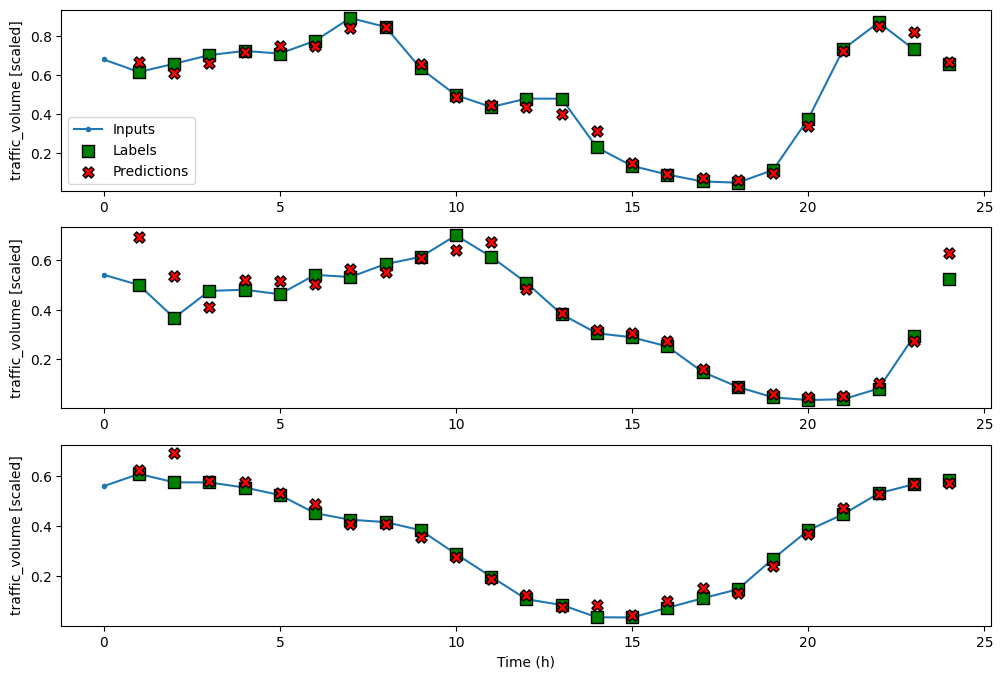

In [14]:
wide_window.plot(lstm_model)

plt.savefig('figures/CH15_F09_peixeiro.png', dpi=300)

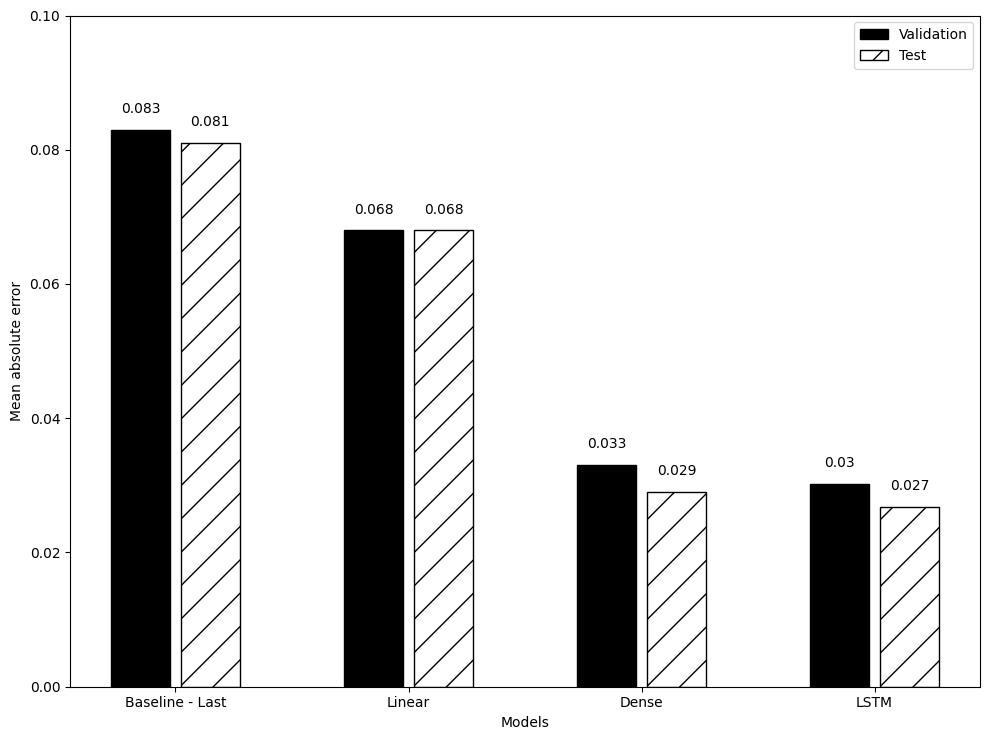

In [15]:
mae_val.append(val_performance['LSTM'][1])
mae_test.append(performance['LSTM'][1])

x = np.arange(4)

labels = ['Baseline - Last', 'Linear', 'Dense', 'LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
plt.ylim(0, 0.1)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

plt.savefig('figures/CH15_F10_peixeiro.png', dpi=300)

### Multi-step model 

In [16]:
multi_window = DataWindow(input_width=24, label_width=24, shift=24, label_columns=['traffic_volume'])

In [17]:
# Values obtained from chapter 14

ms_mae_val = [0.352, 0.347, 0.088, 0.078]
ms_mae_test = [0.347, 0.341, 0.076, 0.064]

In [18]:
# ms_lstm_model = Sequential([
#     LSTM(32, return_sequences=True),
#     Dense(1, kernel_initializer=tf.initializers.zeros),
# ])

ms_lstm_model = Sequential([
    tf.keras.layers.RNN(
        tf.keras.layers.LSTMCell(32),
        return_sequences=True
    ),
    Dense(units=1, kernel_initializer=tf.initializers.zeros)
])

history = compile_and_fit(ms_lstm_model, multi_window, batch_size=32)   # , batch_size=32 added because running out of GPU memory

ms_val_performance = {}
ms_performance = {}

ms_val_performance['LSTM'] = ms_lstm_model.evaluate(multi_window.val)
ms_performance['LSTM'] = ms_lstm_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
    383/Unknown 4s 6ms/step - loss: 0.0964 - mean_absolute_error: 0.2386

2026-02-19 14:26:15.786827: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:26:15.786849: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


383/383 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0501 - mean_absolute_error: 0.1628 - val_loss: 0.0206 - val_mean_absolute_error: 0.1006
Epoch 2/50
 52/383 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0190 - mean_absolute_error: 0.0971

2026-02-19 14:26:16.836547: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:26:16.836599: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0167 - mean_absolute_error: 0.0895 - val_loss: 0.0175 - val_mean_absolute_error: 0.0882
Epoch 3/50


2026-02-19 14:26:18.068213: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:26:18.068253: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:26:18.254428: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:26:18.254464: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0150 - mean_absolute_error: 0.0827 - val_loss: 0.0171 - val_mean_absolute_error: 0.0891


2026-02-19 14:26:19.480781: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:26:19.480804: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:26:19.678887: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:26:19.678910: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


Epoch 4/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0144 - mean_absolute_error: 0.0802 - val_loss: 0.0162 - val_mean_absolute_error: 0.0823
Epoch 5/50


2026-02-19 14:26:20.900012: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:26:20.900045: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:26:21.087396: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:26:21.087417: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


377/383 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0143 - mean_absolute_error: 0.0793

2026-02-19 14:26:22.319760: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:26:22.319806: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0141 - mean_absolute_error: 0.0788 - val_loss: 0.0161 - val_mean_absolute_error: 0.0811
Epoch 6/50
 51/383 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0146 - mean_absolute_error: 0.0797

2026-02-19 14:26:22.531802: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:26:22.531822: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0138 - mean_absolute_error: 0.0776 - val_loss: 0.0159 - val_mean_absolute_error: 0.0847
Epoch 7/50


2026-02-19 14:26:23.767353: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:26:23.767385: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:26:23.960175: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:26:23.960196: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0135 - mean_absolute_error: 0.0768 - val_loss: 0.0156 - val_mean_absolute_error: 0.0792
Epoch 8/50


2026-02-19 14:26:25.175717: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:26:25.175769: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:26:25.365799: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:26:25.365819: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0133 - mean_absolute_error: 0.0762 - val_loss: 0.0150 - val_mean_absolute_error: 0.0795
Epoch 9/50


2026-02-19 14:26:26.634213: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:26:26.634249: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:26:26.822478: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:26:26.822500: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0131 - mean_absolute_error: 0.0755 - val_loss: 0.0149 - val_mean_absolute_error: 0.0813
Epoch 10/50


2026-02-19 14:26:28.033747: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:26:28.033782: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:26:28.224243: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:26:28.224266: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


370/383 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0129 - mean_absolute_error: 0.0747

2026-02-19 14:26:29.430357: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:26:29.430382: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0129 - mean_absolute_error: 0.0747 - val_loss: 0.0149 - val_mean_absolute_error: 0.0787
Epoch 11/50
 49/383 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0132 - mean_absolute_error: 0.0751

2026-02-19 14:26:29.636620: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:26:29.636641: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0128 - mean_absolute_error: 0.0741 - val_loss: 0.0146 - val_mean_absolute_error: 0.0806
Epoch 12/50


2026-02-19 14:26:30.887403: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:26:30.887425: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:26:31.068321: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:26:31.068344: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


382/383 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0127 - mean_absolute_error: 0.0738

2026-02-19 14:26:32.290404: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:26:32.290449: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0127 - mean_absolute_error: 0.0737 - val_loss: 0.0145 - val_mean_absolute_error: 0.0777
Epoch 13/50
 49/383 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0126 - mean_absolute_error: 0.0730

2026-02-19 14:26:32.502787: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:26:32.502811: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0126 - mean_absolute_error: 0.0734 - val_loss: 0.0148 - val_mean_absolute_error: 0.0807
Epoch 14/50


2026-02-19 14:26:33.740284: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:26:33.740340: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:26:33.926793: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:26:33.926813: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0125 - mean_absolute_error: 0.0728 - val_loss: 0.0144 - val_mean_absolute_error: 0.0764
Epoch 15/50


2026-02-19 14:26:35.136262: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:26:35.136293: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:26:35.328332: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:26:35.328353: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0123 - mean_absolute_error: 0.0723 - val_loss: 0.0139 - val_mean_absolute_error: 0.0778
Epoch 16/50


2026-02-19 14:26:36.545424: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:26:36.545508: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:26:36.737366: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:26:36.737388: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0122 - mean_absolute_error: 0.0717 - val_loss: 0.0139 - val_mean_absolute_error: 0.0756
Epoch 17/50


2026-02-19 14:26:38.005081: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:26:38.005134: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:26:38.192199: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:26:38.192220: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0121 - mean_absolute_error: 0.0716

2026-02-19 14:26:39.408181: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:26:39.408240: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0120 - mean_absolute_error: 0.0713 - val_loss: 0.0135 - val_mean_absolute_error: 0.0751
Epoch 18/50
 52/383 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0120 - mean_absolute_error: 0.0714

2026-02-19 14:26:39.623121: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:26:39.623175: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0118 - mean_absolute_error: 0.0706 - val_loss: 0.0135 - val_mean_absolute_error: 0.0731
Epoch 19/50


2026-02-19 14:26:40.838985: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:26:40.839030: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:26:41.029886: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:26:41.029917: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0116 - mean_absolute_error: 0.0698 - val_loss: 0.0137 - val_mean_absolute_error: 0.0765


2026-02-19 14:26:42.236616: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:26:42.435781: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:26:42.435810: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


Epoch 20/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0115 - mean_absolute_error: 0.0694 - val_loss: 0.0135 - val_mean_absolute_error: 0.0723
Epoch 21/50


2026-02-19 14:26:43.655067: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:26:43.655093: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:26:43.844280: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:26:43.844303: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0114 - mean_absolute_error: 0.0689 - val_loss: 0.0132 - val_mean_absolute_error: 0.0728
Epoch 22/50


2026-02-19 14:26:45.069179: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:26:45.069202: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:26:45.256382: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:26:45.256411: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0112 - mean_absolute_error: 0.0683 - val_loss: 0.0136 - val_mean_absolute_error: 0.0744
Epoch 23/50


2026-02-19 14:26:46.479680: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:26:46.479709: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:26:46.677176: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:26:46.677199: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0112 - mean_absolute_error: 0.0679 - val_loss: 0.0133 - val_mean_absolute_error: 0.0774
Epoch 24/50


2026-02-19 14:26:47.880624: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:26:47.880649: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:26:48.071832: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:26:48.071866: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0112 - mean_absolute_error: 0.0680 - val_loss: 0.0127 - val_mean_absolute_error: 0.0706
Epoch 25/50
 51/383 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0107 - mean_absolute_error: 0.0660

2026-02-19 14:26:49.554858: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:26:49.554882: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0110 - mean_absolute_error: 0.0672 - val_loss: 0.0129 - val_mean_absolute_error: 0.0712
Epoch 26/50


2026-02-19 14:26:50.768705: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:26:50.768757: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:26:50.960195: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:26:50.960215: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0108 - mean_absolute_error: 0.0667 - val_loss: 0.0127 - val_mean_absolute_error: 0.0699
Epoch 27/50


2026-02-19 14:26:52.167768: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:26:52.167804: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:26:52.356887: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:26:52.356911: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0108 - mean_absolute_error: 0.0666 - val_loss: 0.0125 - val_mean_absolute_error: 0.0693
Epoch 28/50


2026-02-19 14:26:53.575949: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:26:53.575992: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:26:53.770477: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:26:53.770502: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0108 - mean_absolute_error: 0.0663 - val_loss: 0.0128 - val_mean_absolute_error: 0.0691
Epoch 29/50


2026-02-19 14:26:54.993173: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:26:54.993216: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:26:55.185844: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:26:55.185865: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0106 - mean_absolute_error: 0.0657

2026-02-19 14:26:56.403778: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:26:56.403812: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0106 - mean_absolute_error: 0.0657 - val_loss: 0.0125 - val_mean_absolute_error: 0.0685
Epoch 30/50
 51/383 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0106 - mean_absolute_error: 0.0658

2026-02-19 14:26:56.617128: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2026-02-19 14:26:56.617155: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:26:56.617163: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0106 - mean_absolute_error: 0.0656 - val_loss: 0.0121 - val_mean_absolute_error: 0.0686
Epoch 31/50


2026-02-19 14:26:57.828324: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:26:57.828360: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:26:58.019234: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:26:58.019270: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


378/383 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0106 - mean_absolute_error: 0.0654

2026-02-19 14:26:59.248385: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:26:59.248420: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:26:59.446901: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:26:59.446923: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0105 - mean_absolute_error: 0.0654 - val_loss: 0.0124 - val_mean_absolute_error: 0.0719
Epoch 32/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0104 - mean_absolute_error: 0.0650 - val_loss: 0.0121 - val_mean_absolute_error: 0.0707
Epoch 33/50


2026-02-19 14:27:00.707852: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:27:00.897348: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:27:00.897373: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0104 - mean_absolute_error: 0.0647 - val_loss: 0.0119 - val_mean_absolute_error: 0.0693
Epoch 34/50


2026-02-19 14:27:02.108186: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:27:02.108225: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:27:02.301733: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:27:02.301765: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0103 - mean_absolute_error: 0.0644 - val_loss: 0.0122 - val_mean_absolute_error: 0.0677
Epoch 35/50


2026-02-19 14:27:03.518701: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:27:03.518722: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:27:03.708302: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:27:03.708325: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0102 - mean_absolute_error: 0.0642 - val_loss: 0.0120 - val_mean_absolute_error: 0.0696
Epoch 36/50
 51/383 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0100 - mean_absolute_error: 0.0636

2026-02-19 14:27:05.100497: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:27:05.100534: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0102 - mean_absolute_error: 0.0641

2026-02-19 14:27:06.325588: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:27:06.325613: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:27:06.526274: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:27:06.526297: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0102 - mean_absolute_error: 0.0642 - val_loss: 0.0120 - val_mean_absolute_error: 0.0677
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0120 - mean_absolute_error: 0.0677


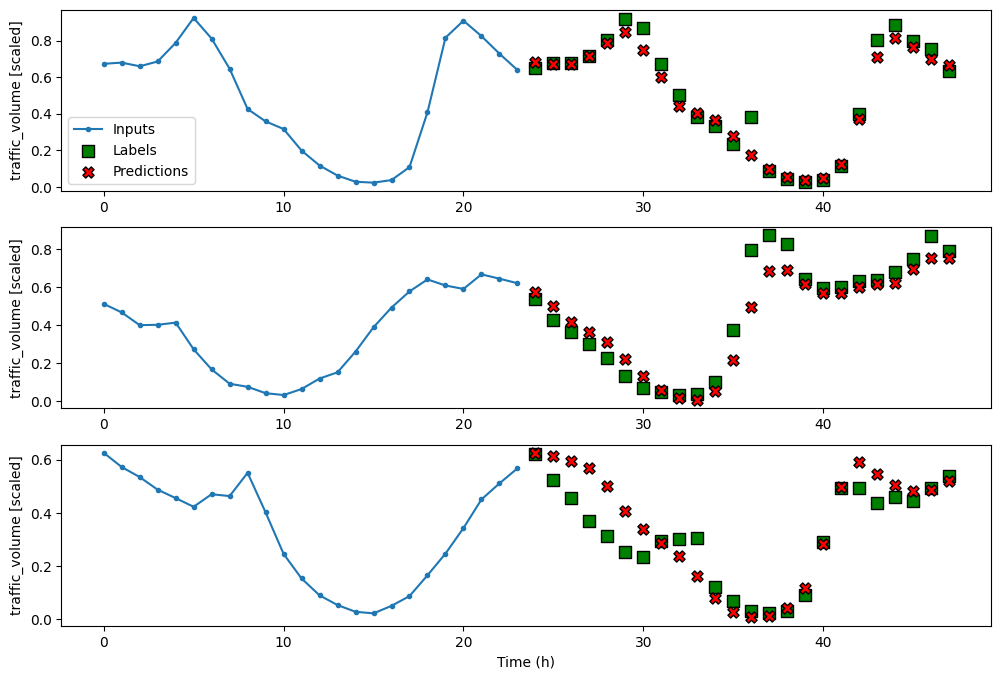

In [19]:
multi_window.plot(ms_lstm_model)

plt.savefig('figures/CH15_F11_peixeiro.png', dpi=300)

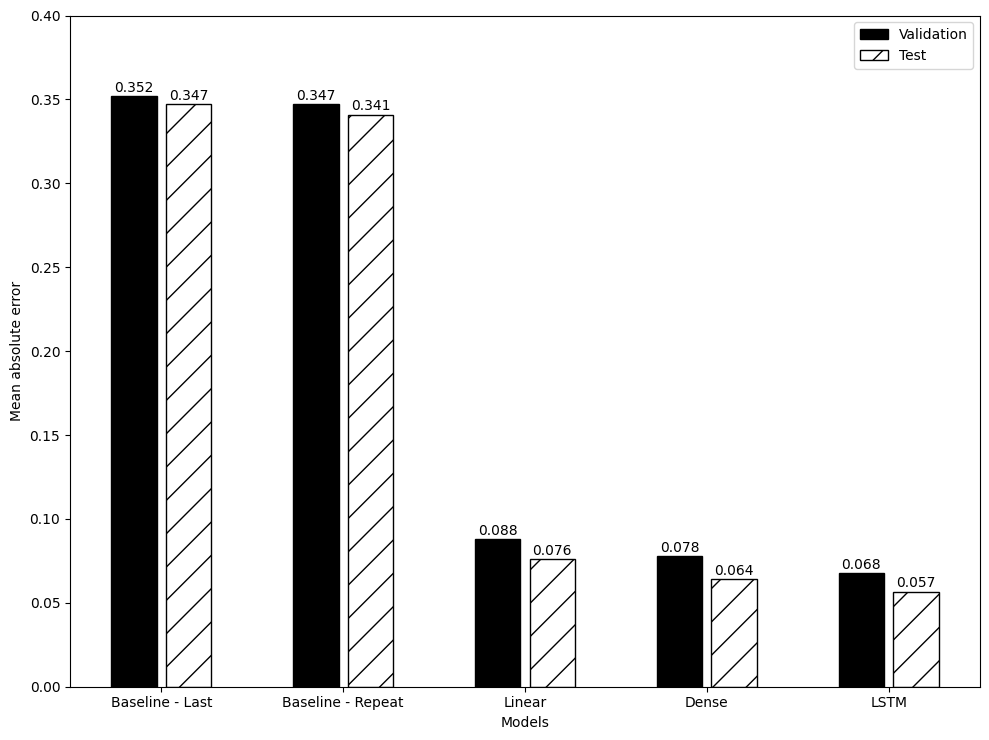

In [20]:
ms_mae_val.append(ms_val_performance['LSTM'][1])
ms_mae_test.append(ms_performance['LSTM'][1])

x = np.arange(5)

labels = ['Baseline - Last', 'Baseline - Repeat', 'Linear', 'Dense', 'LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, ms_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, ms_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(ms_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(ms_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.4)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

plt.savefig('figures/CH15_F12_peixeiro.png', dpi=300)

### Multi-output model 

In [21]:
mo_single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['temp','traffic_volume']) 
mo_wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['temp','traffic_volume'])

In [22]:
# Values from chapter 14

mo_mae_val = [0.048, 0.039, 0.023]
mo_mae_test = [0.047, 0.036, 0.020]

In [23]:
# mo_lstm_model = Sequential([
#     LSTM(32, return_sequences=True),
#     Dense(units = 2)
# ])

mo_lstm_model = Sequential([
    tf.keras.layers.RNN(
        tf.keras.layers.LSTMCell(32),
        return_sequences=True
    ),
    Dense(units=2)
])

history = compile_and_fit(mo_lstm_model, mo_wide_window, batch_size=32)   # , batch_size=32 added because running out of GPU memory

mo_val_performance = {}
mo_performance = {}

mo_val_performance['LSTM'] = mo_lstm_model.evaluate(mo_wide_window.val)
mo_performance['LSTM'] = mo_lstm_model.evaluate(mo_wide_window.test, verbose=0)

Epoch 1/50
    384/Unknown 4s 6ms/step - loss: 0.0699 - mean_absolute_error: 0.1836

2026-02-19 14:27:13.238781: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:27:13.238828: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


384/384 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0320 - mean_absolute_error: 0.1154 - val_loss: 0.0116 - val_mean_absolute_error: 0.0670
Epoch 2/50
 47/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0104 - mean_absolute_error: 0.0657

2026-02-19 14:27:14.271406: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:27:14.271452: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0073 - mean_absolute_error: 0.0541 - val_loss: 0.0050 - val_mean_absolute_error: 0.0448
Epoch 3/50


2026-02-19 14:27:15.528528: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:27:15.528560: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:27:15.718947: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:27:15.718970: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0039 - mean_absolute_error: 0.0390 - val_loss: 0.0030 - val_mean_absolute_error: 0.0347
Epoch 4/50


2026-02-19 14:27:16.971098: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:27:16.971135: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:27:17.155497: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:27:17.155518: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


374/384 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0031 - mean_absolute_error: 0.0348

2026-02-19 14:27:18.408190: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:27:18.408220: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0029 - mean_absolute_error: 0.0339 - val_loss: 0.0023 - val_mean_absolute_error: 0.0314
Epoch 5/50
 50/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0026 - mean_absolute_error: 0.0330

2026-02-19 14:27:18.612900: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:27:18.612920: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0025 - mean_absolute_error: 0.0311 - val_loss: 0.0021 - val_mean_absolute_error: 0.0295
Epoch 6/50


2026-02-19 14:27:19.868786: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:27:19.868820: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:27:20.059200: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:27:20.059221: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


377/384 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0023 - mean_absolute_error: 0.0297

2026-02-19 14:27:21.299300: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:27:21.299330: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0023 - mean_absolute_error: 0.0291 - val_loss: 0.0019 - val_mean_absolute_error: 0.0272
Epoch 7/50
 52/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0022 - mean_absolute_error: 0.0285

2026-02-19 14:27:21.526259: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:27:21.526282: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0021 - mean_absolute_error: 0.0276 - val_loss: 0.0018 - val_mean_absolute_error: 0.0260
Epoch 8/50


2026-02-19 14:27:22.759653: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:27:22.759712: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:27:22.950087: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:27:22.950133: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


372/384 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0020 - mean_absolute_error: 0.0270

2026-02-19 14:27:24.261998: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:27:24.262044: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:27:24.464106: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:27:24.464129: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0020 - mean_absolute_error: 0.0267 - val_loss: 0.0016 - val_mean_absolute_error: 0.0253
Epoch 9/50
375/384 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0019 - mean_absolute_error: 0.0263

2026-02-19 14:27:25.717763: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:27:25.717814: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:27:25.919362: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:27:25.919386: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0019 - mean_absolute_error: 0.0261 - val_loss: 0.0016 - val_mean_absolute_error: 0.0248
Epoch 10/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0018 - mean_absolute_error: 0.0256 - val_loss: 0.0015 - val_mean_absolute_error: 0.0244
Epoch 11/50


2026-02-19 14:27:27.161771: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:27:27.161816: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:27:27.346997: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:27:27.347017: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0018 - mean_absolute_error: 0.0251 - val_loss: 0.0015 - val_mean_absolute_error: 0.0237
Epoch 12/50


2026-02-19 14:27:28.601327: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:27:28.601369: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:27:28.788659: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:27:28.788678: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0017 - mean_absolute_error: 0.0246 - val_loss: 0.0014 - val_mean_absolute_error: 0.0236
Epoch 13/50


2026-02-19 14:27:30.035410: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:27:30.035437: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:27:30.229685: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:27:30.229723: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0017 - mean_absolute_error: 0.0243 - val_loss: 0.0014 - val_mean_absolute_error: 0.0236
Epoch 14/50


2026-02-19 14:27:31.453007: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:27:31.453028: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:27:31.648089: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:27:31.648112: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0016 - mean_absolute_error: 0.0240 - val_loss: 0.0014 - val_mean_absolute_error: 0.0235
Epoch 15/50


2026-02-19 14:27:32.885063: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:27:32.885089: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:27:33.075988: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:27:33.076009: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


374/384 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016 - mean_absolute_error: 0.0238

2026-02-19 14:27:34.326469: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:27:34.326497: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0016 - mean_absolute_error: 0.0237 - val_loss: 0.0013 - val_mean_absolute_error: 0.0226
Epoch 16/50
 50/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0016 - mean_absolute_error: 0.0236

2026-02-19 14:27:34.528936: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:27:34.528961: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0016 - mean_absolute_error: 0.0235 - val_loss: 0.0013 - val_mean_absolute_error: 0.0228
Epoch 17/50


2026-02-19 14:27:35.828822: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:27:35.828865: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:27:36.017007: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:27:36.017030: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0016 - mean_absolute_error: 0.0233 - val_loss: 0.0013 - val_mean_absolute_error: 0.0232
Epoch 18/50


2026-02-19 14:27:37.257961: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:27:37.257990: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:27:37.449365: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:27:37.449386: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0015 - mean_absolute_error: 0.0232 - val_loss: 0.0013 - val_mean_absolute_error: 0.0228
Epoch 19/50


2026-02-19 14:27:38.723160: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:27:38.723206: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:27:38.919357: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:27:38.919377: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0015 - mean_absolute_error: 0.0230 - val_loss: 0.0013 - val_mean_absolute_error: 0.0219


2026-02-19 14:27:40.163473: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:27:40.163501: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:27:40.359040: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:27:40.359060: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


Epoch 20/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0015 - mean_absolute_error: 0.0229 - val_loss: 0.0014 - val_mean_absolute_error: 0.0241
Epoch 21/50


2026-02-19 14:27:46.009312: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:27:46.009349: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:27:46.205244: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:27:46.205267: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0015 - mean_absolute_error: 0.0228 - val_loss: 0.0013 - val_mean_absolute_error: 0.0224
Epoch 22/50


2026-02-19 14:27:47.487683: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:27:47.487722: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:27:47.675597: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:27:47.675616: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0015 - mean_absolute_error: 0.0228 - val_loss: 0.0012 - val_mean_absolute_error: 0.0216
Epoch 23/50


2026-02-19 14:27:48.923986: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:27:48.924028: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:27:49.118877: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:27:49.118899: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


376/384 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0015 - mean_absolute_error: 0.0227

2026-02-19 14:27:50.371009: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:27:50.371037: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0015 - mean_absolute_error: 0.0225 - val_loss: 0.0012 - val_mean_absolute_error: 0.0219
Epoch 24/50
 49/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0014 - mean_absolute_error: 0.0227

2026-02-19 14:27:50.591655: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:27:50.591678: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0015 - mean_absolute_error: 0.0225 - val_loss: 0.0012 - val_mean_absolute_error: 0.0221
Epoch 25/50


2026-02-19 14:27:51.844220: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:27:51.844257: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:27:52.041198: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:27:52.041241: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0014 - mean_absolute_error: 0.0224 - val_loss: 0.0012 - val_mean_absolute_error: 0.0217
Epoch 26/50


2026-02-19 14:27:53.853598: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:27:53.853650: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:27:54.045308: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0014 - mean_absolute_error: 0.0222 - val_loss: 0.0012 - val_mean_absolute_error: 0.0215
Epoch 27/50


2026-02-19 14:27:55.289673: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:27:55.289731: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:27:55.484468: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:27:55.484492: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0014 - mean_absolute_error: 0.0222 - val_loss: 0.0011 - val_mean_absolute_error: 0.0209
Epoch 28/50


2026-02-19 14:27:56.744467: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:27:56.744501: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:27:56.929806: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:27:56.929827: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0014 - mean_absolute_error: 0.0222 - val_loss: 0.0012 - val_mean_absolute_error: 0.0216
Epoch 29/50


2026-02-19 14:27:58.163857: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:27:58.163888: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:27:58.354610: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:27:58.354643: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0014 - mean_absolute_error: 0.0220 - val_loss: 0.0012 - val_mean_absolute_error: 0.0219
Epoch 30/50


2026-02-19 14:27:59.655514: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:27:59.655544: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:27:59.845487: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:27:59.845508: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0014 - mean_absolute_error: 0.0219 - val_loss: 0.0011 - val_mean_absolute_error: 0.0207
Epoch 31/50


2026-02-19 14:28:01.608740: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:28:01.608770: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:28:01.798100: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:28:01.798120: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0014 - mean_absolute_error: 0.0218 - val_loss: 0.0012 - val_mean_absolute_error: 0.0219
Epoch 32/50


2026-02-19 14:28:03.053649: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:28:03.053706: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:28:03.248927: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:28:03.248948: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014 - mean_absolute_error: 0.0218

2026-02-19 14:28:04.476580: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:28:04.476601: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:28:04.675876: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:28:04.675898: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0014 - mean_absolute_error: 0.0217 - val_loss: 0.0011 - val_mean_absolute_error: 0.0210
Epoch 33/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0014 - mean_absolute_error: 0.0217 - val_loss: 0.0011 - val_mean_absolute_error: 0.0205
Epoch 34/50


2026-02-19 14:28:05.916580: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:28:05.916609: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:28:06.113304: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:28:06.113327: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


381/384 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014 - mean_absolute_error: 0.0217

2026-02-19 14:28:07.346640: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:28:07.346677: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0014 - mean_absolute_error: 0.0216 - val_loss: 0.0011 - val_mean_absolute_error: 0.0207
Epoch 35/50
 50/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0013 - mean_absolute_error: 0.0218

2026-02-19 14:28:07.559777: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:28:07.559803: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0013 - mean_absolute_error: 0.0216 - val_loss: 0.0011 - val_mean_absolute_error: 0.0205
Epoch 36/50


2026-02-19 14:28:08.814744: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:28:08.814782: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:28:09.004383: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:28:09.004404: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0013 - mean_absolute_error: 0.0214 - val_loss: 0.0010 - val_mean_absolute_error: 0.0200
Epoch 37/50


2026-02-19 14:28:10.283891: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:28:10.283933: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:28:10.469827: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:28:10.469852: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0013 - mean_absolute_error: 0.0213 - val_loss: 0.0010 - val_mean_absolute_error: 0.0202
Epoch 38/50


2026-02-19 14:28:11.736976: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:28:11.737027: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:28:11.929835: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:28:11.929858: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0013 - mean_absolute_error: 0.0212 - val_loss: 0.0010 - val_mean_absolute_error: 0.0199
Epoch 39/50


2026-02-19 14:28:13.182521: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:28:13.182567: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:28:13.376507: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:28:13.376528: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0013 - mean_absolute_error: 0.0212 - val_loss: 0.0010 - val_mean_absolute_error: 0.0195
Epoch 40/50


2026-02-19 14:28:14.630572: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:28:14.630616: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:28:14.820684: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:28:14.820729: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0013 - mean_absolute_error: 0.0210 - val_loss: 0.0010 - val_mean_absolute_error: 0.0200
Epoch 41/50


2026-02-19 14:28:16.069472: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:28:16.069509: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:28:16.257829: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:28:16.257858: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0013 - mean_absolute_error: 0.0210 - val_loss: 0.0010 - val_mean_absolute_error: 0.0200
Epoch 42/50


2026-02-19 14:28:17.515878: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:28:17.515904: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:28:17.706509: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:28:17.706530: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0013 - mean_absolute_error: 0.0209 - val_loss: 0.0010 - val_mean_absolute_error: 0.0204


2026-02-19 14:28:18.949563: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:28:18.949618: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349
2026-02-19 14:28:19.141565: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 604372705834099419
2026-02-19 14:28:19.141594: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6274965600665066349


109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0010 - mean_absolute_error: 0.0204  


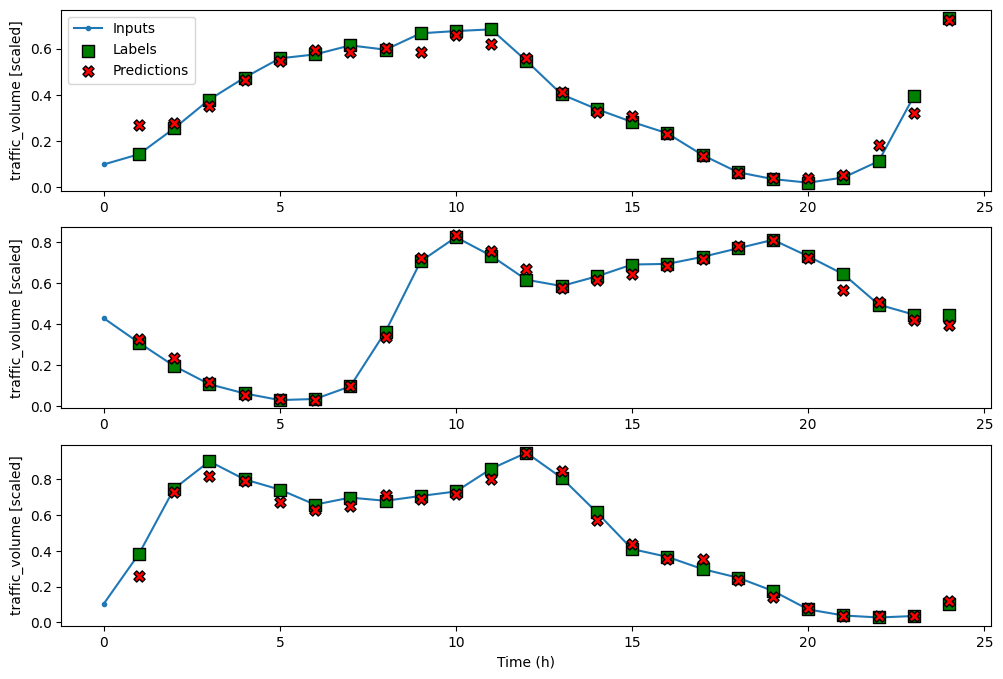

In [24]:
mo_wide_window.plot(mo_lstm_model)

plt.savefig('figures/CH15_F13_peixeiro.png', dpi=300)

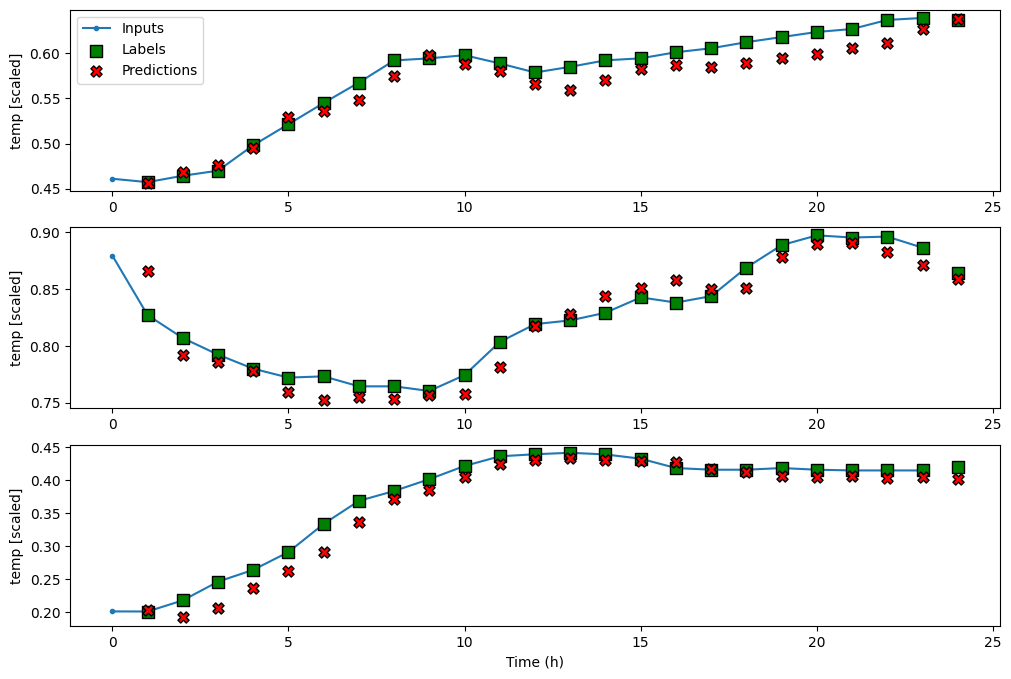

In [25]:
mo_wide_window.plot(model=mo_lstm_model, plot_col='temp')

plt.savefig('figures/CH15_F14_peixeiro.png', dpi=300)

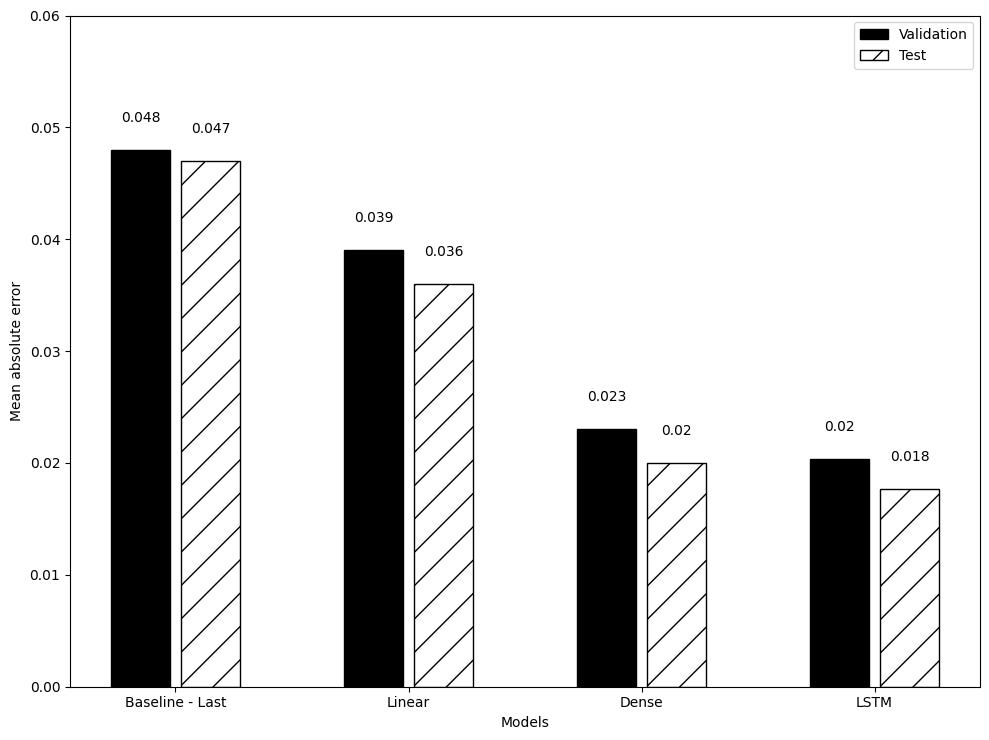

In [26]:
mo_mae_val.append(mo_val_performance['LSTM'][1])
mo_mae_test.append(mo_performance['LSTM'][1])

x = np.arange(4)

labels = ['Baseline - Last', 'Linear', 'Dense', 'LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, mo_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mo_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mo_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mo_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.06)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

plt.savefig('figures/CH15_F15_peixeiro.png', dpi=300)

In [27]:
end = time.perf_counter()

elapsed_time = end - start
print(f"Elapsed time: {elapsed_time:.4f} seconds")

Elapsed time: 196.2392 seconds


3.12 RNN+LSTMCell Elapsed time: 196.2392 seconds